## Imports

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures

from classifiers.random_classifier import RandomClassifier
from classifiers.majority_classifier import MajorityClassifier
from classifiers.naive_bayes_classifier import NaiveBayesClassifier
from classifiers.logistic_regression_classifier import LogisticRegressionClassifier
from classifiers.decision_tree_classifier import DecisionTreeClassifier

In [2]:
train_df = pd.read_csv('./seminar_2/train.csv')

In [3]:
train_df.head()

,Index,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V33,V34,V35,V36,V37,V38,V39,V40,V41,Class
0,3,3.932,3.2512,0,0.0,0,0,0,26.7,2,...,0,0,1,3.076,2.417,0,7.601,0,0,2
1,5,4.236,3.3944,0,0.0,0,0,0,29.4,2,...,0,0,0,3.351,2.405,0,8.003,0,0,2
2,6,4.236,3.4286,0,0.0,0,0,0,28.6,2,...,0,0,0,3.351,2.556,0,7.904,0,0,2
3,7,5.000,5.0476,1,0.0,0,0,0,11.1,0,...,0,0,1,4.712,4.583,0,9.303,0,0,2
4,8,4.525,3.8301,0,0.0,0,0,0,31.6,3,...,0,0,0,3.379,2.143,0,7.950,0,0,2


In [4]:
test_df = pd.read_csv('./seminar_2/test.csv')

In [5]:
test_df.head()

,Index,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V33,V34,V35,V36,V37,V38,V39,V40,V41,Class
0,1,3.919,2.6909,0,0,0,0,0,31.4,2,...,0,0,0,2.949,1.591,0,7.253,0,0,2
1,2,4.170,2.1144,0,0,0,0,0,30.8,1,...,0,0,0,3.315,1.967,0,7.257,0,0,2
2,4,3.000,2.7098,0,0,0,0,0,20.0,0,...,0,0,1,3.046,5.000,0,6.690,0,0,2
3,13,4.214,2.6272,0,0,0,0,0,30.0,3,...,0,0,0,2.998,1.722,0,6.770,0,0,2
4,16,3.942,2.7719,1,0,0,0,0,31.6,2,...,0,0,0,3.542,1.739,0,8.127,0,1,2


## Exploration

In [6]:
class_counts = train_df["Class"].value_counts()

In [7]:
print("Class 1: ", class_counts[1], "percentage: ", class_counts[1]/len(train_df))
print("Class 2: ", class_counts[2], "percantage:", class_counts[2]/len(train_df))

Class 1:  564 percentage:  0.6666666666666666
Class 2:  282 percantage: 0.3333333333333333


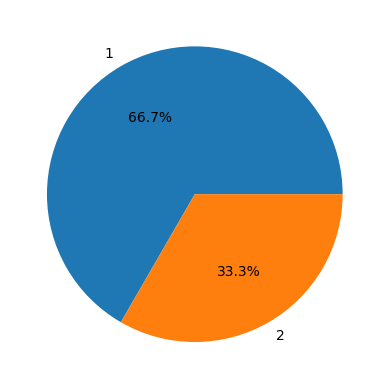

In [8]:
p = plt.pie(x=class_counts, labels=class_counts.index, autopct='%1.1f%%')

The target variable is binary, with the value 1 indicating that the chemical is bio-degradable and 2 indicating that it is not bio-degradable. The dataset is imbalanced, with 1's representing 66.7% of the data and 2's representing 33.3% of the data.

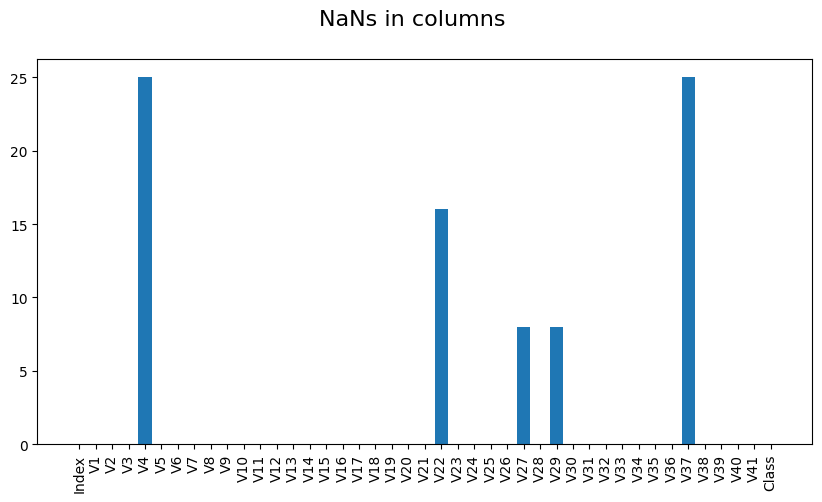

In [9]:
nans = train_df.isnull().sum(axis = 0)

fig = plt.figure(figsize=(10, 5))
fig.suptitle('NaNs in columns', fontsize=16)
plt.bar(nans.index, nans.values)
plt.xticks(rotation=90)
plt.show()

There are a few NaN values in the dataset, but not a lot. We assume that dropping these rows will not have a significant impact on the model, but we will also test the model with imputation such as taking the mean value.

In [10]:
correlation_in_data = train_df.corr()

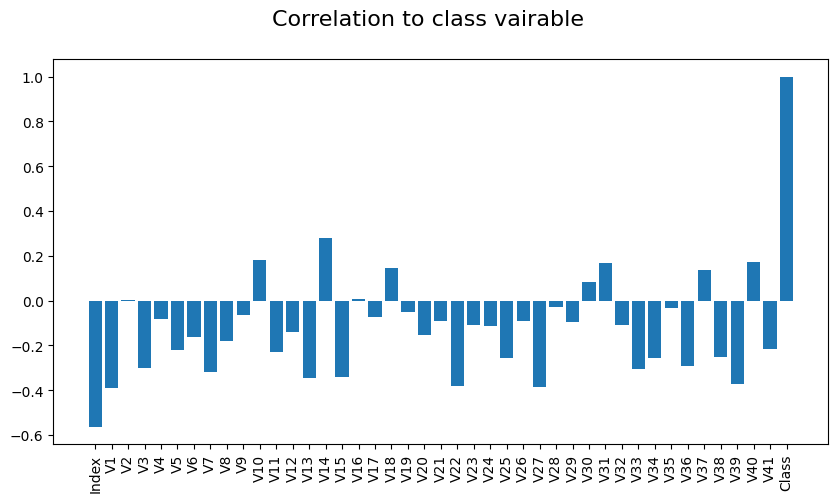

In [11]:
correlation_to_class = correlation_in_data["Class"]

fig = plt.figure(figsize=(10, 5))
fig.suptitle('Correlation to class vairable', fontsize=16)
plt.bar(correlation_to_class.index, correlation_to_class.values)
plt.xticks(rotation=90)
plt.show()

No features have a very high direct correlation to the target variable, but quite a lot of features have some correlation.

<AxesSubplot: >

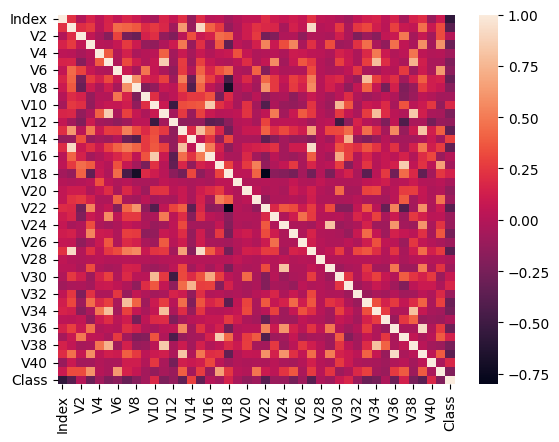

In [12]:
sns.heatmap(correlation_in_data, fmt=".2f")

We can see that most features are not directly correlated to one another, but there are some brighter spots on the heatmap indicating some correlation between features.

In [13]:
correlated_columns = set()
threshold = 0.75

for i in range(len(correlation_in_data.columns)):
    for j in range(i):
        if abs(correlation_in_data.iloc[i, j]) > threshold:
            colname1 = correlation_in_data.columns[i]
            colname2 = correlation_in_data.columns[j]
            correlated_columns.add((colname1, colname2, correlation_in_data.iloc[i, j]))

print(correlated_columns)
print(len(correlated_columns), "highly correlated features")

{('V38', 'V11', 0.8368979414216005), ('V27', 'V1', 0.921560062534691), ('V39', 'V36', 0.9165966103510599), ('V30', 'V10', 0.7577897873010442), ('V37', 'V17', 0.8498222432021918), ('V39', 'V13', 0.8135703600627614), ('V38', 'V34', 0.7988417285560266), ('V22', 'V18', -0.8008371258856498), ('V33', 'V7', 0.7858011767376897), ('V16', 'V10', 0.8439634438135399), ('V15', 'V1', 0.90971096205887), ('V11', 'V5', 0.8590175645510726), ('V29', 'V24', 0.8046206066746212), ('V34', 'V5', 0.7827712292006271), ('V34', 'V11', 0.7852915815925773), ('V15', 'V13', 0.791588421036705), ('V27', 'V15', 0.9230962155600061)}
17 highly correlated features


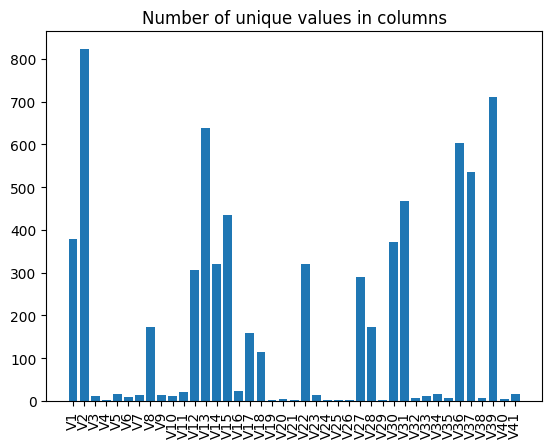

In [14]:
train_df_without_index_and_class = train_df.drop(["Index", "Class"], axis=1)
plt.bar(train_df_without_index_and_class.nunique().index, train_df_without_index_and_class.nunique().values)
plt.xticks(rotation=90)
plt.title("Number of unique values in columns")
plt.show()

Text(0.5, 1.0, 'Outliers of all columns')

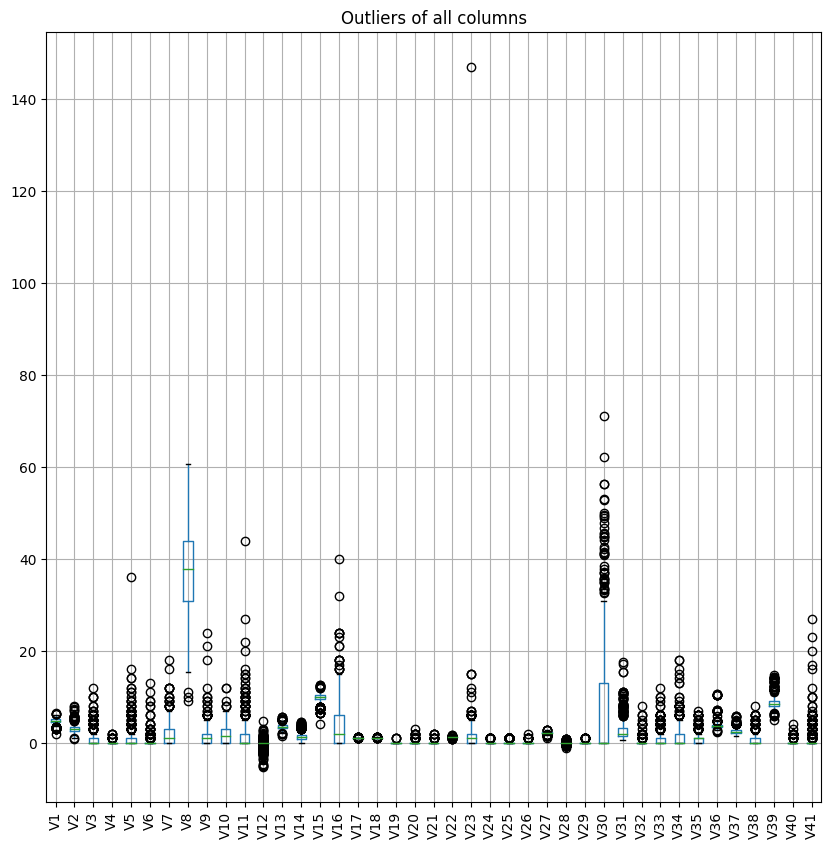

In [15]:
train_df_without_index_and_class.boxplot(figsize=(10, 10))
plt.xticks(rotation=90)
plt.title("Outliers of all columns")

By plotting the distribution of the features, we can see that most features have some outlies. We will test the model with and without outlier removal, we assume that removing the outliers will have a significant impact on the model.

In [16]:
continuous_columns =  [i for i in train_df_without_index_and_class.nunique().index.where(train_df_without_index_and_class.nunique().values >= 100) if i is not None]
" ".join(continuous_columns)

'V1 V2 V8 V12 V13 V14 V15 V17 V18 V22 V27 V28 V30 V31 V36 V37 V39'

## Modeling

We decided that we will test models with differently preprocessed data to see which preprocessing method works best. We will test the following preprocessing methods:
- Dropping NaN values
- Replacing NaN values with the mean value
- Dropping outliers
- Polynomial features

In [157]:
train_data = train_df.drop(["Index"], axis=1)
without_nan = train_data.dropna(axis=0)
nan_replaced = train_data.fillna(without_nan.mean())
without_outliers = without_nan[(np.abs(stats.zscore(without_nan)) < 3).all(axis=1)]

In [173]:
trans = PolynomialFeatures(degree=3)
poli_data = trans.fit_transform(without_nan.drop(["Class"], axis=1))
size = poli_data.shape[1]
poli_data = np.hstack((poli_data, without_nan["Class"].values.reshape(-1, 1)))
poli_data = pd.DataFrame(poli_data, columns=[f"poly_{i}" for i in range(size)] + ["Class"])

In [158]:
test_data = test_df.drop(["Index"], axis=1)
test_data_without_nan = test_data.dropna(axis=0)
test_data_nan_replaced = test_data.fillna(test_data_without_nan.mean())
test_data_without_outliers = test_data_without_nan

In [175]:
poli_test = trans.transform(test_data_without_nan.drop(["Class"], axis=1))
size = poli_test.shape[1]
poli_test = np.hstack((poli_test, test_data_without_nan["Class"].values.reshape(-1, 1)))
poli_test = pd.DataFrame(poli_test, columns=[f"poly_{i}" for i in range(size)] + ["Class"])

In [40]:
def split_data(data, target_column):
    return data.drop([target_column], axis=1), data[target_column]

We have decided to test the following models:
- Random classifier (as a baseline)
- Majority classifier (as a baseline)
- Naive Bayes classifier (because it is fast and simple)
- Logistic regression (because it is good for binary classification)
- Decision tree (because it is good for high dimensional data)

### Random Classifier

In [41]:
train_features, train_target = split_data(train_data, "Class")
best_rnd = RandomClassifier(train_features, train_target)
best_rnd_data = train_data.copy()

### Majority Classifier

In [42]:
train_features, train_target = split_data(train_data, "Class")
maj_classifier = MajorityClassifier(train_features, train_target)
best_maj_data = train_data.copy()

### Naive Bayes Modeling

In [199]:
wnan_features, wnan_target = split_data(without_nan, "Class")
wnan_test_features, wnan_test_target = split_data(test_data_without_nan, "Class")
without_nan_nb = NaiveBayesClassifier(wnan_features, wnan_target)

In [200]:
mean_features, mean_target = split_data(nan_replaced, "Class")
mean_test_features, mean_test_target = split_data(test_data_nan_replaced, "Class")
mean_nb = NaiveBayesClassifier(mean_features, mean_target)

In [48]:
slight_smoothing_nan_nb = NaiveBayesClassifier(wnan_features, wnan_target, var_smoothing=10e-9)

In [49]:
heavy_smoothing_nan_nb = NaiveBayesClassifier(wnan_features, wnan_target, var_smoothing=10e-12)

In [201]:
outliers_features, outliers_target = split_data(without_outliers, "Class")
outliers_test_features, outliers_test_target = split_data(test_data_without_outliers, "Class")
outliers_nb = NaiveBayesClassifier(outliers_features, outliers_target)

In [202]:
poli_features, poli_target = split_data(poli_data, "Class")
poli_test_features, poli_test_target = split_data(poli_test, "Class")
poli_nb = NaiveBayesClassifier(poli_features, poli_target)

In [203]:
nb_classifiers = [(without_nan_nb, test_data_without_nan), (mean_nb, test_data_nan_replaced), (slight_smoothing_nan_nb, test_data_without_nan), (heavy_smoothing_nan_nb, test_data_without_nan), (outliers_nb, test_data_without_outliers), (poli_nb, poli_test)]

In [204]:
scores = np.empty((len(nb_classifiers), 5))
for i, (c, test_data) in enumerate(nb_classifiers):
    f, t = split_data(test_data, "Class")
    scores[i] = c.evaluate(f, t)

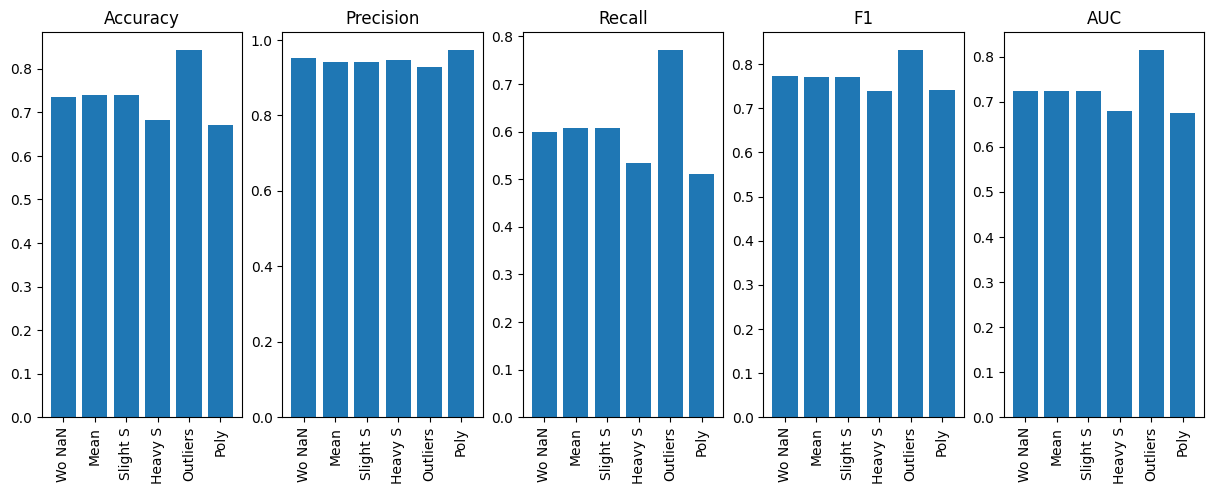

In [205]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

score_names = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
classifiers = ["Wo NaN", "Mean", "Slight S", "Heavy S", "Outliers", "Poly"]
for i in range(5):
    axes[i].bar([i for i in range(len(nb_classifiers))], scores[:, i])
    axes[i].set_title(score_names[i])
    axes[i].set_xticks([i for i in range(len(nb_classifiers))])
    axes[i].set_xticklabels(classifiers)
    axes[i].xaxis.set_tick_params(rotation=90)

### Logistic Regression Modeling

In [44]:
wnan_features, wnan_target = split_data(without_nan, "Class")
without_nan_lr = LogisticRegressionClassifier(wnan_features, wnan_target, solver='lbfgs', max_iter=1000)

In [45]:
mean_features, mean_target = split_data(nan_replaced, "Class")
mean_lr = LogisticRegressionClassifier(mean_features, mean_target, solver='lbfgs', max_iter=1000)

In [52]:
L1_penalty_lr = LogisticRegressionClassifier(mean_features, mean_target, solver='liblinear', max_iter=1000, penalty='l1')

In [56]:
balanced_lr = LogisticRegressionClassifier(mean_features, mean_target, solver='lbfgs', max_iter=1000, class_weight='balanced')

In [102]:
outliers_features, outliers_target = split_data(without_outliers, "Class")
outliers_lr = LogisticRegressionClassifier(outliers_features, outliers_target, solver='lbfgs', max_iter=1000)

In [193]:
poli_features, poli_target = split_data(poli_data, "Class")
poli_lr = LogisticRegressionClassifier(poli_features, poli_target, solver='lbfgs', max_iter=1000, tol=1e-2)

c:\Users\Aleksander\anaconda3\envs\inteligent_systems\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [206]:
lr_classifiers = [(without_nan_lr, test_data_without_nan), (mean_lr, test_data_nan_replaced), (L1_penalty_lr, test_data_nan_replaced), (balanced_lr, test_data_nan_replaced), (outliers_lr, test_data_without_outliers), (poli_lr, poli_test)]

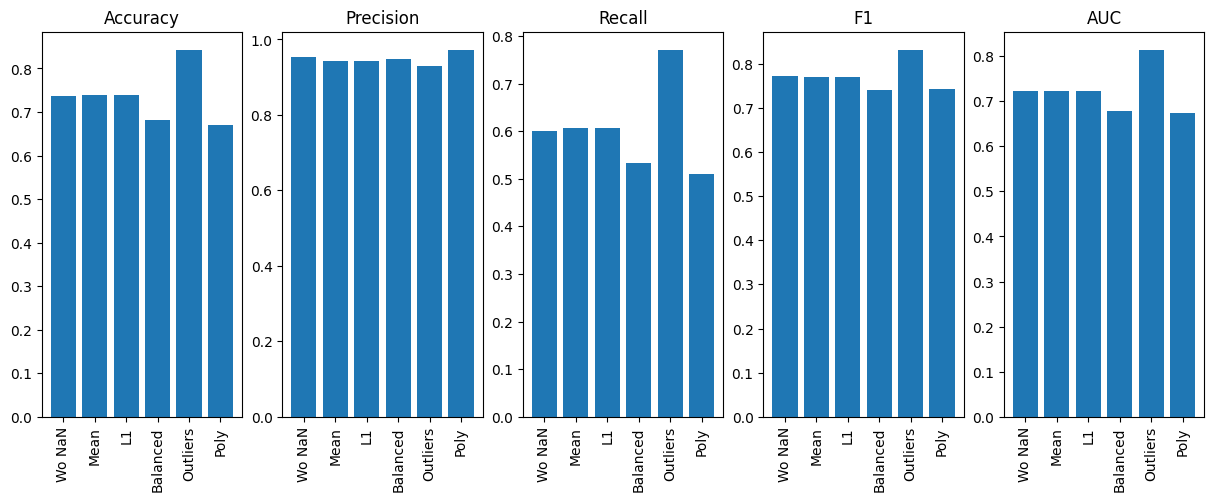

In [207]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

score_names = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
classifiers = ["Wo NaN", "Mean", "L1", "Balanced", "Outliers", "Poly"]
for i in range(5):
    axes[i].bar([i for i in range(len(lr_classifiers))], scores[:, i])
    axes[i].set_title(score_names[i])
    axes[i].set_xticks([i for i in range(len(lr_classifiers))])
    axes[i].set_xticklabels(classifiers)
    axes[i].xaxis.set_tick_params(rotation=90)

### Decision Tree Modeling

In [60]:
wnan_features, wnan_target = split_data(without_nan, "Class")
without_nan_dt = DecisionTreeClassifier(wnan_features, wnan_target, random_state=42)

In [59]:
mean_features, mean_target = split_data(nan_replaced, "Class")
mean_dt = DecisionTreeClassifier(mean_features, mean_target, random_state=42)

In [58]:
limited_df = DecisionTreeClassifier(mean_features, mean_target, random_state=42, max_depth=10)

In [57]:
cc_df = DecisionTreeClassifier(mean_features, mean_target, random_state=42, criterion='entropy', ccp_alpha=0.01)

In [103]:
outliers_features, outliers_target = split_data(without_outliers, "Class")
outliers_dt = DecisionTreeClassifier(outliers_features, outliers_target, random_state=42)

In [196]:
poli_features, poli_target = split_data(poli_data, "Class")
poli_dt = DecisionTreeClassifier(poli_features, poli_target, random_state=42)

In [197]:
dt_classifier = [(without_nan_dt, test_data_without_nan), (mean_dt, test_data_nan_replaced), (limited_df, test_data_nan_replaced), (cc_df, test_data_nan_replaced), (outliers_dt, test_data_without_outliers), (poli_dt, poli_test)]

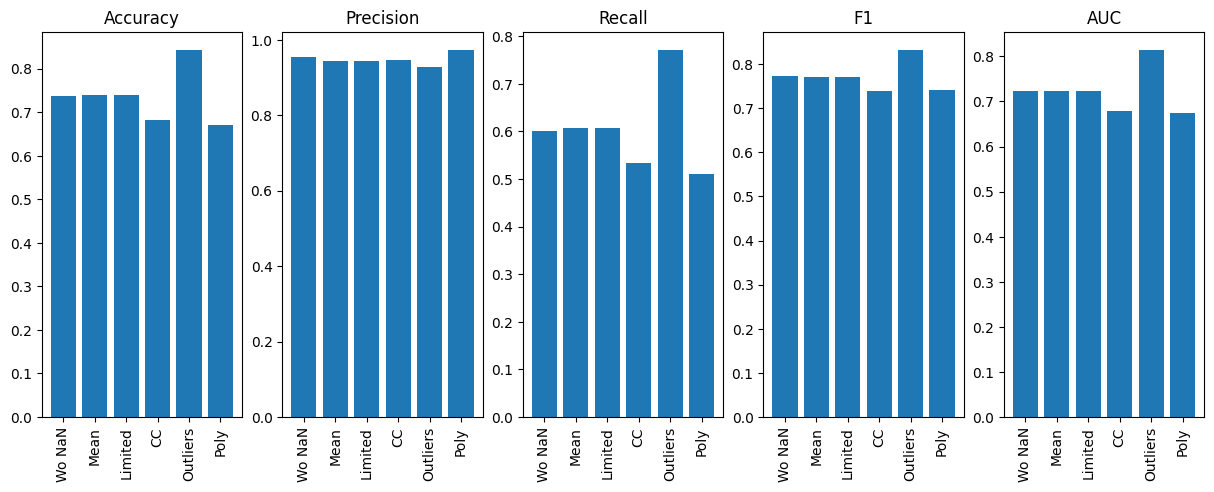

In [208]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

score_names = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
classifiers = ["Wo NaN", "Mean", "Limited", "CC", "Outliers", "Poly"]
for i in range(5):
    axes[i].bar([i for i in range(len(dt_classifier))], scores[:, i])
    axes[i].set_title(score_names[i])
    axes[i].set_xticks([i for i in range(len(dt_classifier))])
    axes[i].set_xticklabels(classifiers)
    axes[i].xaxis.set_tick_params(rotation=90)

### Best Models

In [211]:
best_models = [(best_rnd, best_rnd_data), (maj_classifier, best_maj_data), (outliers_nb, test_data_without_outliers), (outliers_lr, test_data_without_outliers), (outliers_dt, test_data_without_outliers)]

In [212]:
len(best_models)

5

As we can see from testing of the models above removing the outliers had the most significant impact on the model. We will further test these models using folding and multiple runs to see if the results are consistent.

## Evaluation

In [213]:
repetitions = 10
folds = 5
evaluations = 5
scores = np.empty(shape=(len(best_models), repetitions, evaluations))
for i, (classifier, model_data) in enumerate(best_models):
    scores[i] = classifier.test(model_data, "Class", folds=folds, repetitions=repetitions)

(0.0, 1.0, 0.0, 1.0)

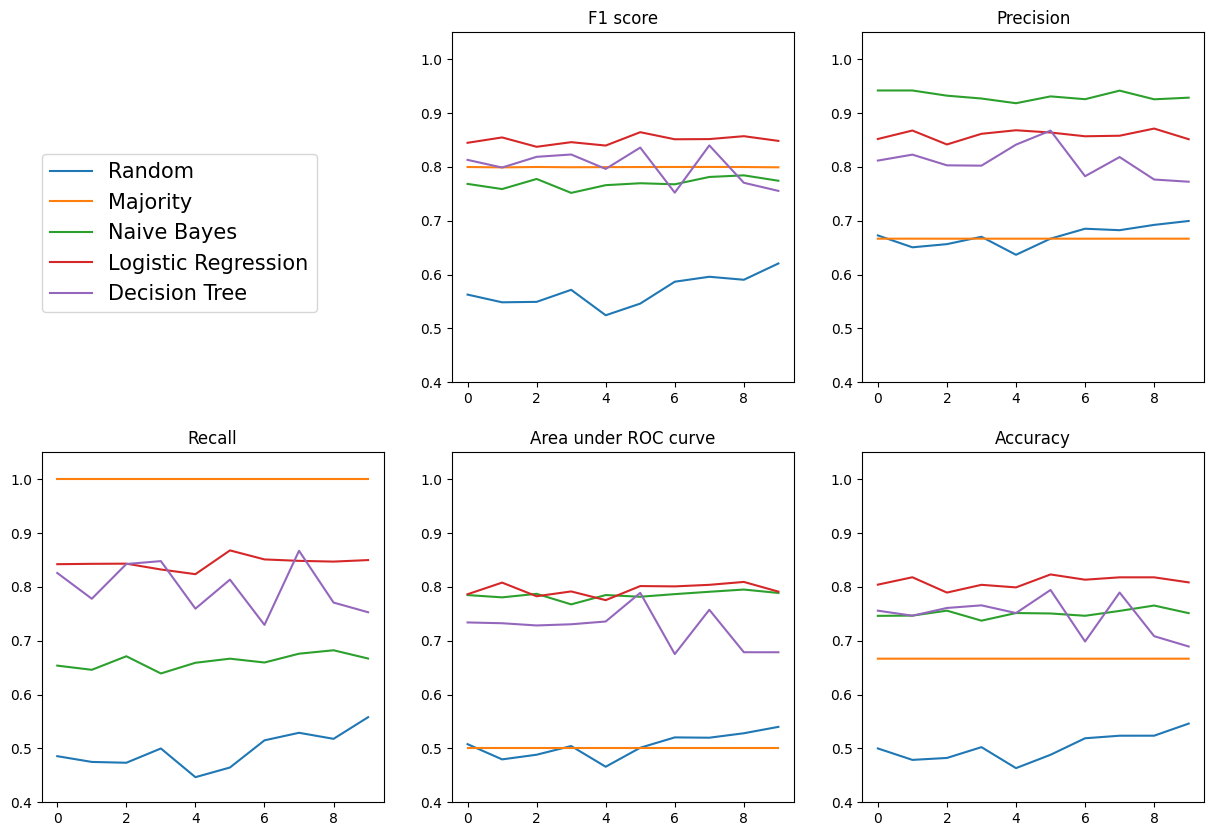

In [214]:
score_names = ["F1 score", "Precision", "Recall", "Area under ROC curve", "Accuracy"]

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(score_names)):
    r = (i + 1) // 3
    c = (i + 1) % 3
    ax[r, c].set_title(score_names[i])
    ax[r, c].plot(scores[0, :,  i], label="Random")
    ax[r, c].plot(scores[1, :,  i], label="Majority")
    ax[r, c].plot(scores[2, :,  i], label="Naive Bayes")
    ax[r, c].plot(scores[3, :,  i], label="Logistic Regression")
    ax[r, c].plot(scores[4, :,  i], label="Decision Tree")
    if i == 0:
        ax[r, c].legend(loc=(-1.2, 0.2), prop={'size': 15})

    ax[r, c].set_ylim(0.4, 1.05)
ax[0, 0].axis("off")

Selected models outpreformed the baseline models. In the recall metric majority classifier was best due to how the metric is calculated (majority classifier cannot produce false negatives as the majority class in training data is positive).

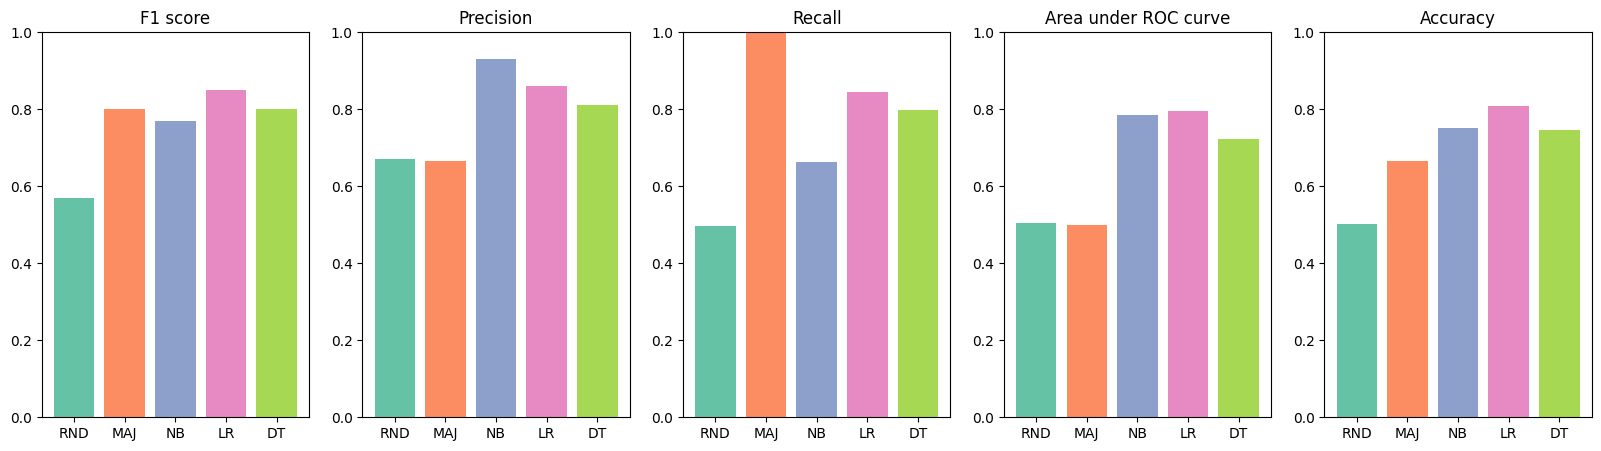

In [215]:
fig, ax = plt.subplots(1, len(score_names), figsize=(len(score_names) * 4, 5))

for i in range(len(score_names)):
    ax[i].set_title(score_names[i])
    ax[i].bar(["RND", "MAJ", "NB", "LR", "DT"], scores.mean(axis=1)[:, i], color=sns.color_palette("Set2", 10))
    ax[i].set_ylim(0, 1)

We chose logistic regression because it preforms best in most metrics (but not by a large margin), but we also decided to test Naive Bayes because for our problem Precision is very important, we do not want to classify non-biodegradable chemicals as biodegradable. Naive Bayes preformed better in Precision metric, but worse in Recall metric.

In [218]:
lr_classifier, lr_train = best_models[3]
nb_classifiers, nb_train = best_models[2]

In [219]:
train_features, train_target = split_data(lr_train, "Class")

In [220]:
lr_classifier.fit(train_features, train_target)
lr_classifier.evaluate(train_features, train_target)

(0.9037037037037037,
 0.9037037037037037,
 0.9037037037037037,
 0.864014014014014,
 0.8755980861244019)

In [221]:
nb_classifiers.fit(train_features, train_target)
nb_classifiers.evaluate(train_features, train_target)

(0.7982456140350878,
 0.978494623655914,
 0.674074074074074,
 0.8235235235235235,
 0.7799043062200957)

Running the models on test data we can see that they performed as expected. Logistic regression preformed better in all metrics, but precision where Naive Bayes performed better achieving a score of 0.97.